In [351]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import warnings
import pandas as pd
import random

style.use("seaborn-white")
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

In [224]:
# optimization methods
def nelder_mead(f, x, y_true, init_params, bounds, eps=0.001, max_iters=1000):
    opt_fn = lambda t: loss(f, x=x, a=t[0], b=t[1], c=t[2], d=t[3], y_true=y_true)
    result = optimize.minimize(opt_fn, x0=init_params, method="Nelder-Mead", bounds=bounds, 
                               options={"maxiter": max_iters, "xatol": eps, "fatol": eps}
    )
    return result.x, result.fun, result.nfev, result.nit

def levenberg_marquardt(f, x, y_true, init_params, bounds, eps=0.001, max_iters=1000):
    def func(params):
        return f(x, params[0], params[1], params[2], params[3]) - y_true

    def func_grad(params):
        return eval(f"{f.__name__}_grad")(x, params[0], params[1], params[2], params[3])

    result = optimize.least_squares(
        func, x0=init_params, jac=func_grad, method="lm",
        ftol=eps, gtol=eps, xtol=eps, max_nfev=max_iters
    )
    return result.x, result.cost * 2, result.nfev, result.nfev

def annealing(f, x, y_true, init_params, bounds, eps=0.001, max_iters=1000):
    def func(params):
        return loss(f, x, params[0], params[1], params[2], params[3], y_true)

    result = optimize.dual_annealing(
        func, bounds=bounds, maxiter=max_iters, no_local_search=True, seed=42, x0=init_params
    )
    return result.x, result.fun, result.nfev, result.nit

def part_swarm(f, x, y_true, init_params, bounds, eps=0.001, max_iters=1000):
    def func(params_batch):
        loss_ = []
        for params in params_batch:
            loss_.append(loss(f, x, params[0], params[1], params[2], params[3], y_true))
        return np.array(loss_)
    options = {"c1": 0.5, "c2": 0.3, "w": 0.9}
    optimizer = pyswarms.single.GlobalBestPSO(
        n_particles=20, dimensions=4, options=options, ftol=eps, center=init_params,
    )
    cost, x = optimizer.optimize(func, iters=max_iters)
    return x, cost, max_iters * 10, max_iters

def diff_ev(f, x, y_true, init_params, bounds, eps=1e-3, max_iters=1000):
    def func(params):
        return loss(f, x, params[0], params[1], params[2], params[3], y_true)

    result = optimize.differential_evolution(
        func, bounds=bounds, maxiter=max_iters, tol=eps, atol=eps, seed=42, x0=init_params
    )
    return result.x, result.fun, result.nfev, result.nit

In [225]:
# functions and gradients
def rational(x, a, b, c, d):
    return np.clip((a * x + b) / (x ** 2 + c * x + d), -100, 100)

def rational_grad(x, a, b, c, d):
    nom = a * x + b
    denom = x ** 2 + c * x + d
    zero_grad = ((nom / denom) > 100) & ((nom / denom) < 100)
    grad_ = []
    grad_.append(x / denom)
    grad_.append(1 / denom)
    grad_.append(-nom * x / (denom ** 2))
    grad_.append(-nom / (denom ** 2))
    grad_ = np.array(grad_).T
    grad_[zero_grad] = 0
    return grad_

def loss(f, x, a, b, c, d, y_true):
    return np.sum((f(x, a, b, c, d) - y_true) ** 2)

def loss_grad(f, x, a, b, c, d, y_true):
    return 2 * (f(x, a, b, c, d) - y_true)

def get_noisy_data():
    x = np.arange(0, 3.001, 0.003)
    f_x = 1 / (x ** 2 - 3 * x + 2)
    f_x = np.clip(f_x, -100, 100)
    noise = np.random.normal(size=x.shape)
    return x, f_x, f_x + noise

In [226]:
searches = (nelder_mead, levenberg_marquardt, annealing, diff_ev)

In [309]:
def search_2d_and_plot(f, data, init_params=[0.5]*4, bounds=[(-4,4)]*4, eps=0.001):
    results_calculations = dict()
    results_iters = dict()
    _, axes = plt.subplots(nrows=2, figsize=(25, 30))
    axes[0].scatter(data[0], data[2], label='data', c='b', s=10)
    axes[0].title.set_text(f"Searches results for {f.__name__} approximant")
    true_loss = np.sum((data[2] - data[1]) ** 2)
    axes[0].plot(data[0], data[1], label=f'true_line, loss={round(true_loss, 2)}')
    for search in searches:
        best, f_min, f_calculations, iters = search(
            f=f, x=data[0], y_true=data[2], init_params=init_params, bounds=bounds, eps=eps
        )
        label = f'{search.__name__}, loss={round(f_min, 2)}'
        axes[0].plot(
            data[0], f(data[0], best[0], best[1], best[2], best[3]), label=label, linewidth=3
        )
        results_calculations[search.__name__] = f_calculations
        results_iters[search.__name__] = iters
    
    
    to_plot = pd.DataFrame(zip(
        np.array([[s.__name__]*2 for s in searches]).flatten(), 
        ['iterations', 'f_calculations']*len(searches),
        np.array([[results_iters[k], results_calculations[k]] for k in results_iters]).flatten()
    ), columns=("methods", "metric", "result"))
    sns.barplot(x="methods", hue="metric", y="result", data=to_plot, ax=axes[1], log=True)
    
    axes[0].legend()
    axes[1].title.set_text(f"Searches metrics for {f.__name__} approximant")

In [294]:
data = get_noisy_data()

In [295]:
best_p, _ = optimize.curve_fit(rational, data[0], data[2], maxfev=300000)

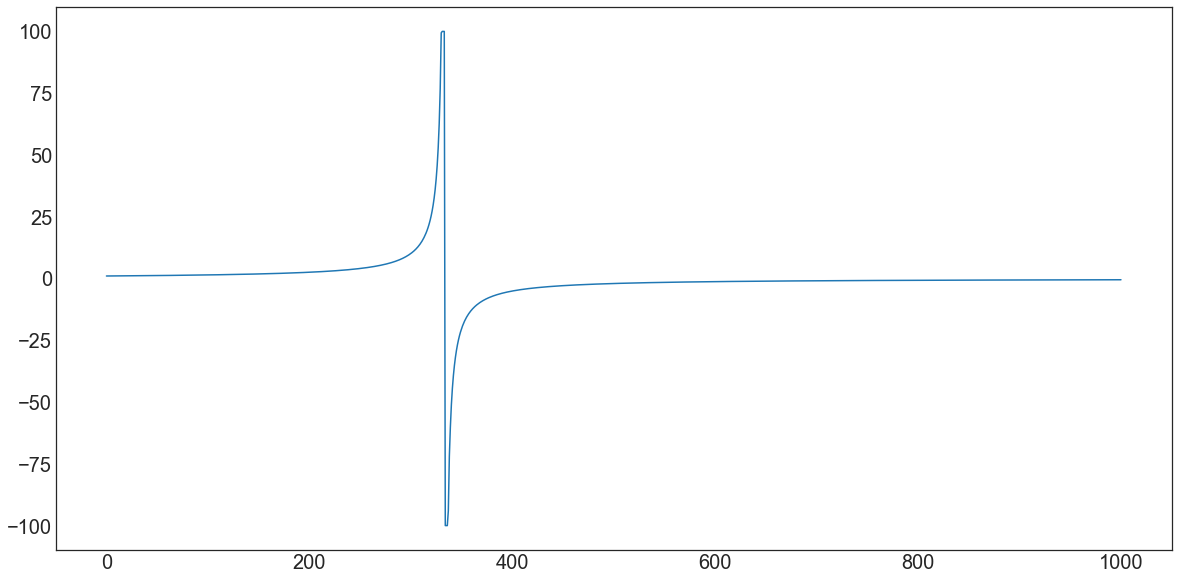

In [296]:
plt.plot(rational(data[0], best_p[0], best_p[1], best_p[2], best_p[3]))

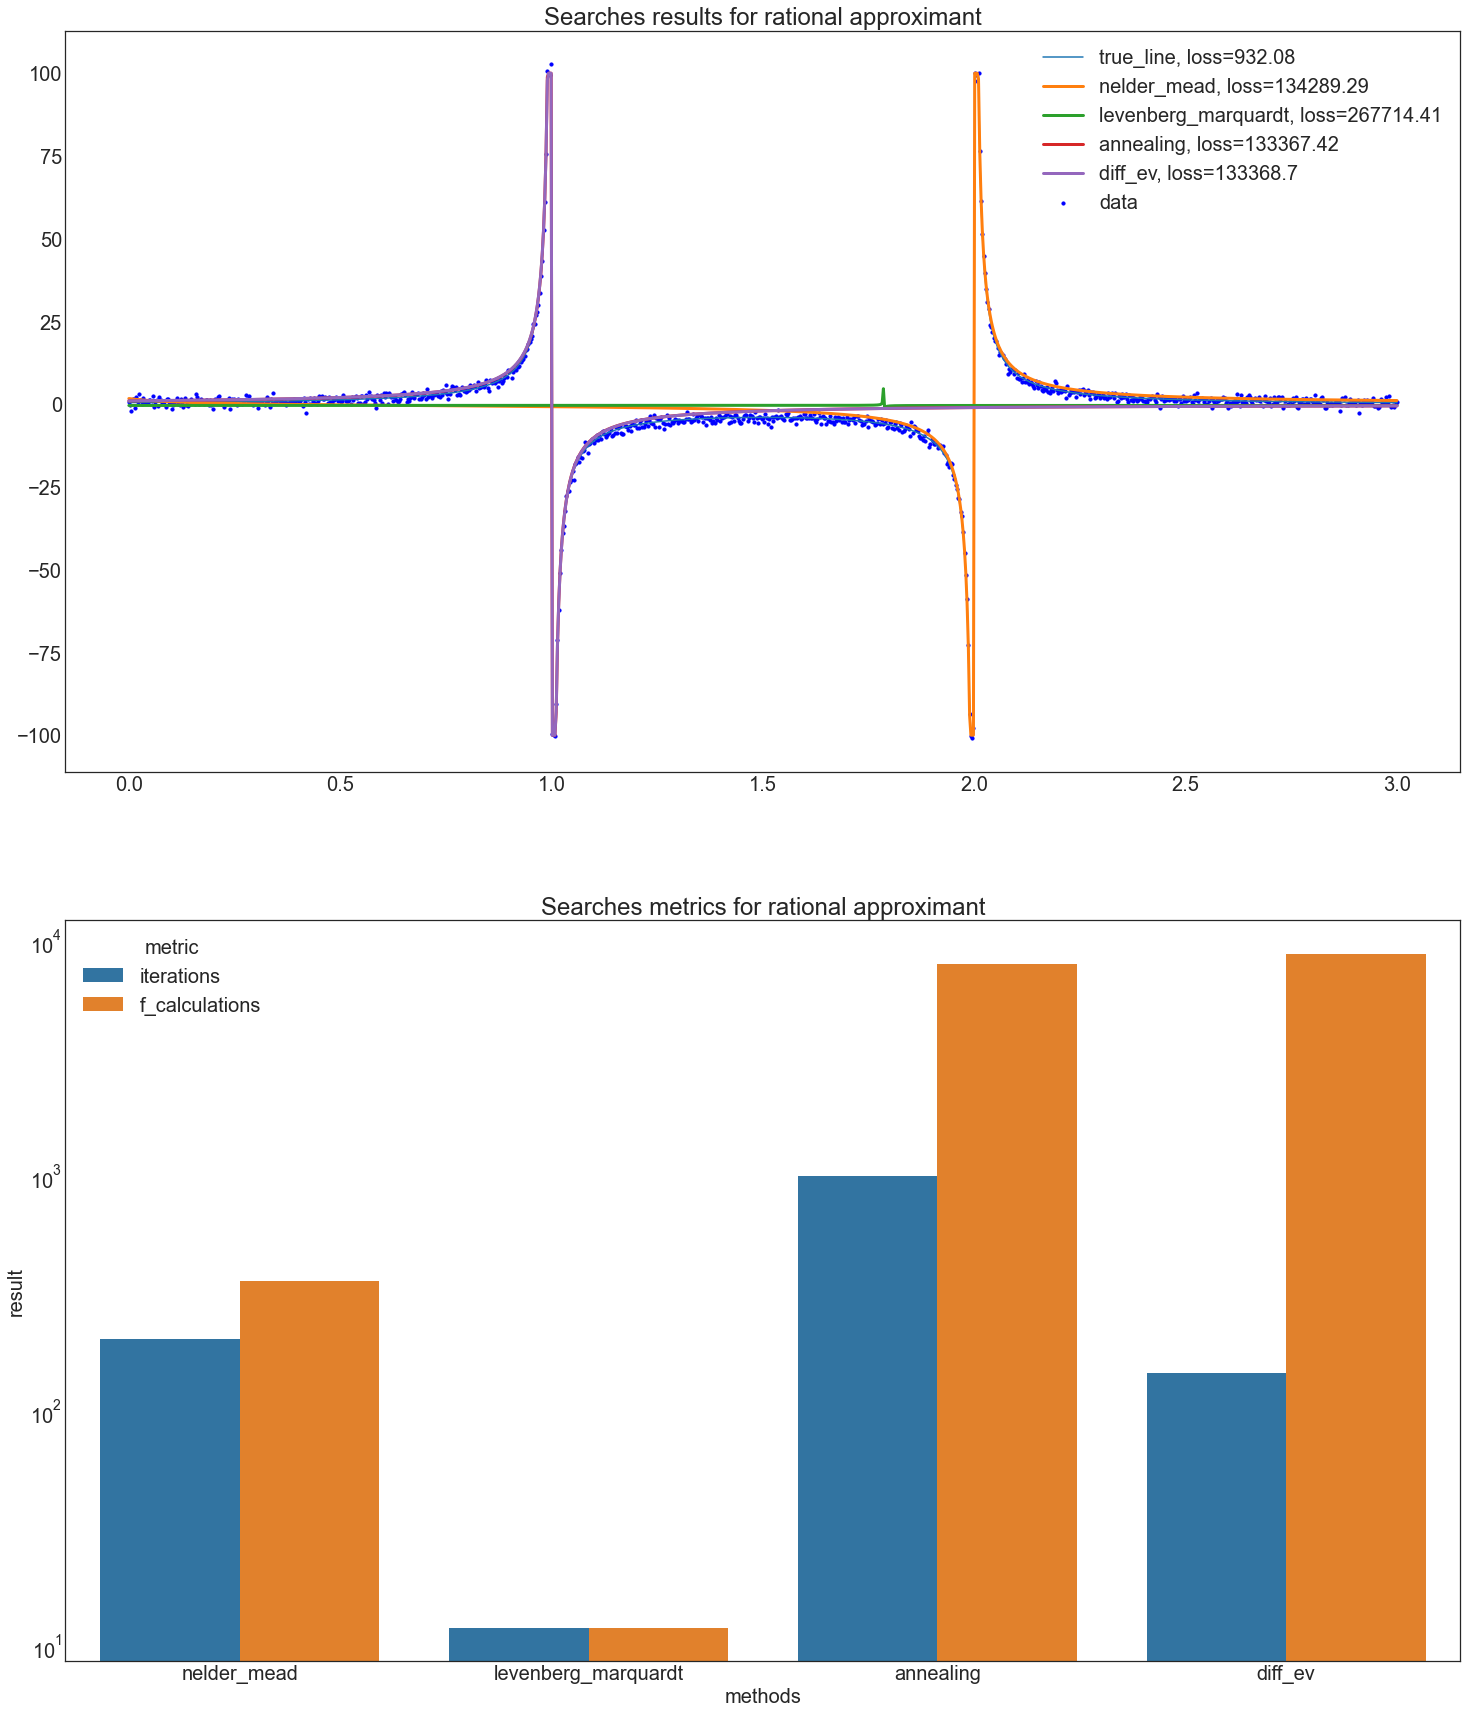

In [340]:
np.random.seed(333)
search_2d_and_plot(rational, data, np.random.uniform(-4, 4, size=4))

### Second part

In [365]:
cities_coords = pd.read_csv('wg22_xy.txt', header=None, delim_whitespace=True)
cities_coords

,0,1
0,-57.0,28.0
1,54.0,-65.0
2,46.0,79.0
3,8.0,111.0
4,-36.0,52.0
5,-22.0,-76.0
6,34.0,129.0
7,74.0,6.0
8,-6.0,-41.0
9,21.0,45.0


In [388]:
# taken from https://github.com/chncyhn/simulated-annealing-tsp
class SimAnneal(object):
    def __init__(self, coords, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        self.coords = coords
        self.N = len(coords)
        self.T = self.N ** 0.5 if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
        self.alpha = 0.995 if alpha == -1 else alpha
        self.stopping_temperature = 1e-8 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 0

        self.nodes = [i for i in range(self.N)]

        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []

    def initial_solution(self):
        """
        Greedy algorithm to get an initial solution (closest-neighbour).
        """
        cur_node = random.choice(self.nodes)  # start from a random node
        solution = [cur_node]

        free_nodes = set(self.nodes)
        free_nodes.remove(cur_node)
        while free_nodes:
            next_node = min(free_nodes, key=lambda x: self.dist(cur_node, x))  # nearest neighbour
            free_nodes.remove(next_node)
            solution.append(next_node)
            cur_node = next_node

        cur_fit = self.fitness(solution)
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        return solution, cur_fit

    def dist(self, node_0, node_1):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = self.coords[node_0], self.coords[node_1]
        return ((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2) ** 0.5

    def fitness(self, solution):
        """
        Total distance of the current solution path.
        """
        cur_fit = 0
        for i in range(self.N):
            cur_fit += self.dist(solution[i % self.N], solution[(i + 1) % self.N])
        return cur_fit

    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current.
        Depends on the current temperature and difference between candidate and current.
        """
        return np.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current.
        Accept with probabilty p_accept(..) if candidate is worse.
        """
        candidate_fitness = self.fitness(candidate)
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate

    def anneal(self):
        """
        Execute simulated annealing algorithm.
        """
        # Initialize with the greedy solution.
        self.cur_solution, self.cur_fitness = self.initial_solution()
        plotTSP([self.cur_solution], self.coords, f'Initial solution, total distance={self.cur_fitness}')
        
        print("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            candidate = list(self.cur_solution)
            l = random.randint(2, self.N - 1)
            i = random.randint(0, self.N - l)
            candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1

            self.fitness_list.append(self.cur_fitness)
            
        plotTSP([self.cur_solution], self.coords, f'Result solution, total distance={self.cur_fitness}')

        print("Best fitness obtained: ", self.best_fitness)
        improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
        print(f"Improvement over greedy heuristic: {improvement : .2f}%")

In [389]:
def plotTSP(paths, points, title, num_iters=1):
    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list
    """
    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(min(x)*1.1, max(x)*1.1)
    plt.ylim(min(y)*1.1, max(y)*1.1)
    plt.title(title)
    plt.show()

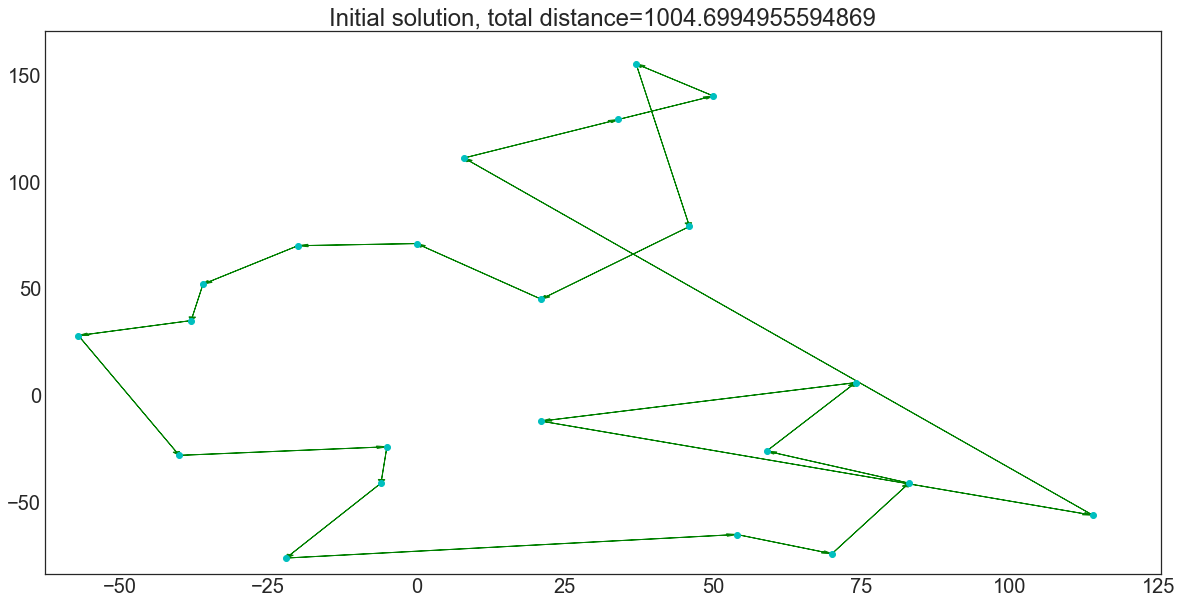

Starting annealing.


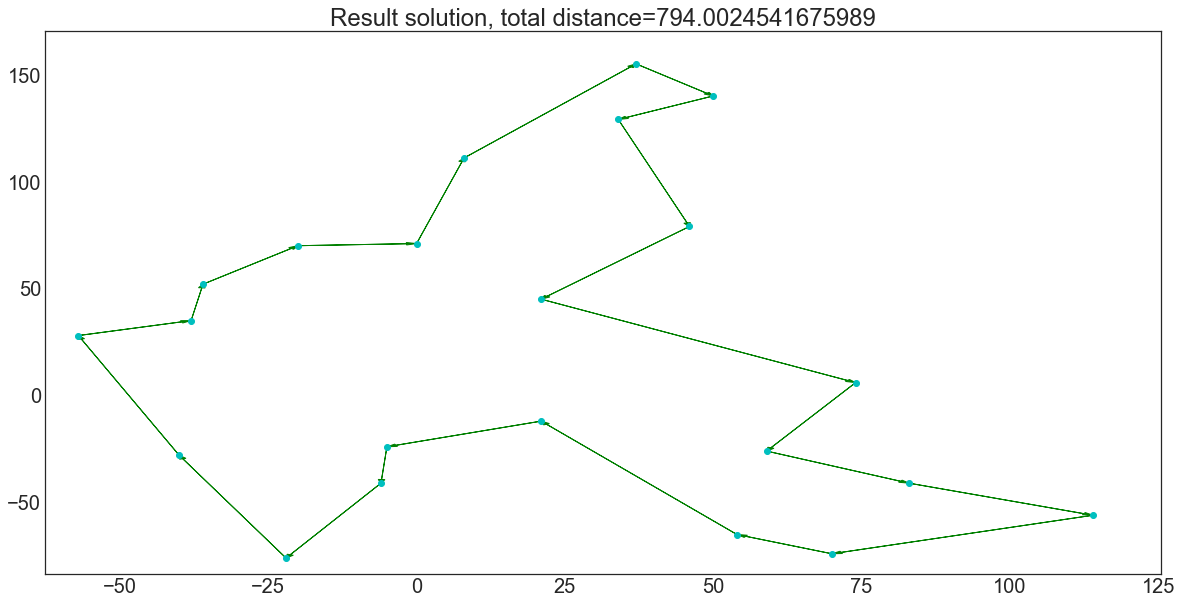

Best fitness obtained:  794.0024541675987
Improvement over greedy heuristic:  20.97%


In [411]:
sa = SimAnneal(cities_coords.values, stopping_iter=2000)
sa.anneal()